# Model on Estado de México

### Load data

In [138]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Autoreload
%load_ext autoreload
%autoreload 2

# Warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
# Import data
from bimbo.data import Bimbo

data = Bimbo().get_data()

# Load in the train and test datasets
train_df = data['train']
# test_df = data['test']
# cliente_tabla_df = data['cliente_tabla']
# producto_tabla_df = data['producto_tabla']
town_state_df = data['town_state']
# sample_submission_df = data['sample_submission']

# Delete data
import gc
del data
gc.collect()

Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.11 MB
Decreased by -184.7%
Memory usage of dataframe is 14.27 MB
Memory usage after optimization is: 19.51 MB
Decreased by -36.7%
Memory usage of dataframe is 373.80 MB
Memory usage after optimization is: 120.15 MB
Decreased by 67.9%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 6.0%
Memory usage of dataframe is 6225.47 MB
Memory usage after optimization is: 2122.32 MB
Decreased by 65.9%
Memory usage of dataframe is 106.80 MB
Memory usage after optimization is: 33.38 MB
Decreased by 68.7%


13873

### Create clusters of Products

In [140]:
products_id_clusters_df = pd.read_csv('../data/producto_clusters.csv')

In [141]:
new_train_df = pd.merge(train_df, products_id_clusters_df, how='left', on='Producto_ID')

### Create a category of location based on zip code

In [142]:
new_train_df = pd.merge(new_train_df, town_state_df, how='left', on='Agencia_ID')

### Feature Engineering

In [143]:
from bimbo.preprocessing import *
from bimbo.feature_engineering import *

In [144]:
new_train_df = new_train_df[new_train_df['State'] == 'ESTADO DE MÉXICO']

In [146]:
new_train_df.head(3)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,short_name,brand,Town,State
75360,3,1112,1,1001,327267,693,5,48.000000,0,0.0,5,Tostada Plana,MR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75361,3,1112,1,1001,327267,1109,5,75.050003,0,0.0,5,Pan Blanco Chico,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75362,3,1112,1,1001,327267,1125,10,96.000000,0,0.0,10,Tortillinas,TR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO


In [8]:
val_df = new_train_df[new_train_df['Semana'] == 8]
test_df = new_train_df[new_train_df['Semana'] == 9]
train_df = new_train_df[new_train_df['Semana'] < 8]

final_y_test = test_df['Demanda_uni_equil'] # for later

# del new_train_df
# gc.collect()

47

In [9]:
# train_df = data_preprocess(train_df)
# val_df = data_preprocess(val_df)
# test_df = data_preprocess(test_df)

In [10]:
# train_df = change_type_to_categ2(train_df)
# val_df = change_type_to_categ2(val_df)
# test_df = change_type_to_categ2(test_df)

In [11]:
# temp = feature_engineering2(train_df)

In [12]:
# val = merge_feature2(val_df, temp, 'val')

In [13]:
# val.to_csv('../data/processed_val_3.csv', index=False)

In [14]:
# frames = [train_df, val_df]
# result = pd.concat(frames)
# temp = feature_engineering2(result)

In [15]:
# test = merge_feature2(test_df, temp, 'test')

In [16]:
# test.to_csv('../data/processed_test_3.csv', index=False)

In [17]:
val = pd.read_csv('../data/processed_val_3.csv')
test = pd.read_csv('../data/processed_test_3.csv')

### Prepare data for XGBoost

In [18]:
X = val.drop('log_demanda_uni_equil', axis=1)
y = val['log_demanda_uni_equil']

In [19]:
from bimbo.xgboost_models import *

In [20]:
# model = build_model(X, y)

### Save model to file

In [21]:
# # save model to file (pickle & joblib)
# save_model(model, "model_estado_mex_1")

### Load model

In [22]:
model = load_model("model_estado_mex_1")

[22:59:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Loaded model from: model_estado_mex_1.joblib.dat


### Data analysis

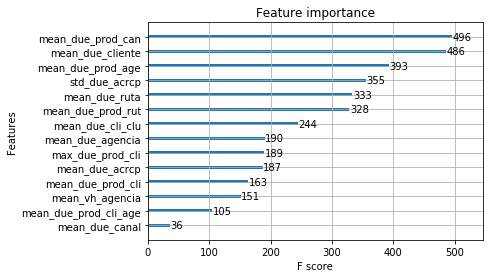

In [23]:
from xgboost import plot_importance

# plot feature importance
plot_importance(model)
plt.show()

- compute on **validation sets**

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y,
        test_size=0.5, random_state=42)

X_train.drop(['Demanda_uni_equil'], axis=1, inplace=True)
X_val.drop(['Demanda_uni_equil'], axis=1, inplace=True)

In [25]:
# make predictions for val data and evaluate
predictions = model.predict(X_val)

In [26]:
final_predictions = np.expm1(predictions).round().astype(int)
final_y_val = np.expm1(y_val).round().astype(int)

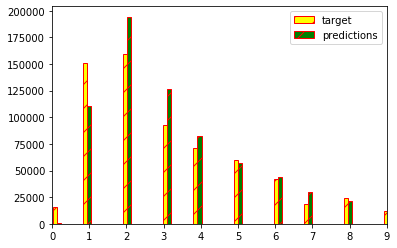

In [27]:
x1 = final_y_val
x2 = pd.Series(final_predictions)
bins = 10000

plt.hist([x1, x2], bins = bins, color = ['yellow', 'green'],
            edgecolor = 'red', hatch = '/', label = ['target', 'predictions'],
            histtype = 'bar')
plt.legend(loc='upper right')
plt.xlim(0, 9)
plt.show()

- compute on **test sets**

In [28]:
log_y_pred = model.predict(test)
final_predictions = np.expm1(log_y_pred).round().astype(int)
y_pred = pd.DataFrame( {'Demanda_uni_equil':final_predictions} )
y_pred = y_pred.rename(columns={"Demanda_uni_equil": "y_pred"})

In [29]:
y_true = pd.DataFrame(final_y_test)
y_true = y_true.rename(columns={"Demanda_uni_equil": "y_true"}).reset_index(drop=True)

In [30]:
final_predictions_unrounded = np.expm1(log_y_pred)
y_pred_unrounded = pd.DataFrame( {'Demanda_uni_equil':final_predictions_unrounded} )
y_pred_unrounded = y_pred_unrounded.rename(columns={"Demanda_uni_equil": "y_pred_unrounded"})

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

mae = mean_absolute_error(y_true, y_pred)
print(f'mae: {mae}')
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'rmse: {rmse}')
rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f'rmsle: {rmsle}')

mae: 2.48647381274031
rmse: 9.897034135665667
rmsle: 0.44978925629463856


In [32]:
analysis_df = pd.concat([test, y_pred, y_true, y_pred_unrounded], axis=1, sort=False)
analysis_df.head(3)

,mean_due_agencia,mean_due_canal,mean_due_ruta,mean_due_cliente,mean_due_prod_age,mean_due_prod_rut,mean_due_prod_cli,mean_due_prod_can,mean_due_prod_cli_age,mean_vh_agencia,std_due_acrcp,mean_due_acrcp,mean_due_cli_clu,max_due_prod_cli,y_pred,y_true,y_pred_unrounded
0,1.552221,1.50034,1.588804,1.524993,1.453920,1.523583,1.443115,1.219733,1.443115,3.496826,0.409800,1.443115,1.443115,1.791760,3,5,2.962265
1,1.552221,1.50034,1.588804,1.524993,1.925682,2.034006,1.958289,1.703149,1.958289,3.496826,0.470728,1.958289,1.886415,2.397895,6,10,6.122163
2,1.552221,1.50034,1.588804,1.524993,1.615046,1.649118,1.804624,1.437196,1.804624,3.496826,0.316486,1.804624,1.886415,2.197225,4,8,4.334697


In [33]:
analysis_df['relative_analysis'] = (abs(analysis_df['y_pred'] - analysis_df['y_true']) / analysis_df['y_true'])
analysis_df['abs_relative_error'] = (abs(analysis_df['y_pred'] - analysis_df['y_true']) / analysis_df['y_true'])
analysis_df['absolute_error'] = (abs(analysis_df['y_pred'] - analysis_df['y_true']))
analysis_df['relative_error'] = (analysis_df['y_true'] - analysis_df['y_pred'])/analysis_df['y_true']

In [34]:
analysis_df['relative_analysis (%)'] = pd.Series(["{0:.2f}%".format(val * 100) for val in analysis_df['relative_analysis']], index = analysis_df.index)

In [35]:
test_df = test_df.reset_index()
df_ = pd.concat([analysis_df, test_df], axis=1, sort=False)

In [36]:
df_ = df_.set_index('index')

In [37]:
df_.columns

Index(['mean_due_agencia', 'mean_due_canal', 'mean_due_ruta',
       'mean_due_cliente', 'mean_due_prod_age', 'mean_due_prod_rut',
       'mean_due_prod_cli', 'mean_due_prod_can', 'mean_due_prod_cli_age',
       'mean_vh_agencia', 'std_due_acrcp', 'mean_due_acrcp',
       'mean_due_cli_clu', 'max_due_prod_cli', 'y_pred', 'y_true',
       'y_pred_unrounded', 'relative_analysis', 'abs_relative_error',
       'absolute_error', 'relative_error', 'relative_analysis (%)', 'Semana',
       'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID',
       'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima',
       'Demanda_uni_equil', 'short_name', 'brand', 'Town', 'State'],
      dtype='object')

---------------------------------------

In [38]:
df_.to_csv('../data/hla_estado_mexico_s9.csv', index=False)

In [84]:
df_.columns

Index(['mean_due_agencia', 'mean_due_canal', 'mean_due_ruta',
       'mean_due_cliente', 'mean_due_prod_age', 'mean_due_prod_rut',
       'mean_due_prod_cli', 'mean_due_prod_can', 'mean_due_prod_cli_age',
       'mean_vh_agencia', 'std_due_acrcp', 'mean_due_acrcp',
       'mean_due_cli_clu', 'max_due_prod_cli', 'y_pred', 'y_true',
       'y_pred_unrounded', 'relative_analysis', 'abs_relative_error',
       'absolute_error', 'relative_error', 'relative_analysis (%)', 'Semana',
       'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID',
       'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima',
       'Demanda_uni_equil', 'short_name', 'brand', 'Town', 'State'],
      dtype='object')

In [39]:
median_relative_value = df_['relative_analysis'].median(skipna = True)
print(f'median relative value: {median_relative_value}')

median relative value: 0.3333333333333333


In [40]:
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

In [99]:
my_list_1 = []
my_list_2 = []
my_list_3 = []
my_list_4 = []
my_list_5 = []
my_list_6 = []
my_list_7 = []
my_list_8 = []
my_dict = {}
i = 0
for el in df_['Agencia_ID'].unique():
    print(f"For Agencia_ID = {el}")
    df_filtered = df_.mask('Agencia_ID', el)
    
    mae = mean_absolute_error(df_filtered['y_true'], df_filtered['y_pred'])
    print(f'mae: {mae}')
    my_list_1.append(mae)
    
    rmse = np.sqrt(mean_squared_error(df_filtered['y_true'], df_filtered['y_pred']))
    print(f'rmse: {rmse}')
    my_list_2.append(rmse)
    
    rmsle = np.sqrt(mean_squared_log_error(df_filtered['y_true'], df_filtered['y_pred']))
    print(f'rmsle: {rmsle}')
    my_list_3.append(rmsle)
    
    abs_relative_error = df_filtered['abs_relative_error'].iloc[i]
    print(f'abs relative error: {abs_relative_error}')
    my_list_4.append(abs_relative_error)
    
    absolute_error = df_filtered['absolute_error'].iloc[i]
    print(f'absolute error: {absolute_error}')
    my_list_5.append(absolute_error)
    
    relative_error = df_filtered['relative_error'].iloc[i]
    print(f'relative error: {relative_error}')
    my_list_6.append(relative_error)
    
    relative_value = df_filtered['relative_analysis'].iloc[i]
    print(f'abs relative value: {relative_value}')
    my_list_7.append(relative_value)
    
    Demanda_uni_equil = df_filtered['Demanda_uni_equil'].iloc[i]
    my_list_8.append(Demanda_uni_equil)
    
    i = 1
    
    print("__________________________")
    print("__________________________")

my_dict.update( {'mae' : my_list_1} )
my_dict.update( {'rmse' : my_list_2} )
my_dict.update( {'rmsle' : my_list_3} )
my_dict.update( {'abs_relative_error' : my_list_4} )
my_dict.update( {'absolute_error' : my_list_5} )
my_dict.update( {'relative_error' : my_list_6} )
my_dict.update( {'relative_analysis' : my_list_7} )
my_dict.update( {'Demanda_uni_equil' : my_list_8} )
df_agencia = pd.DataFrame(data=my_dict)
df_agencia = pd.concat([df_agencia, pd.DataFrame(df_['Agencia_ID'].unique())], \
          axis=1, sort=False)
df_agencia = df_agencia.rename(columns={0: "Agencia_ID"})

For Agencia_ID = 1112
mae: 2.09367829733365
rmse: 4.238568631021158
rmsle: 0.4385705160306678
abs relative error: 0.4
absolute error: 2
relative error: 0.4
abs relative value: 0.4
__________________________
__________________________
For Agencia_ID = 1117
mae: 2.1630366819508127
rmse: 5.1254987862080075
rmsle: 0.4524851868169408
abs relative error: 0.25
absolute error: 1
relative error: -0.25
abs relative value: 0.25
__________________________
__________________________
For Agencia_ID = 1119
mae: 2.2003914640060973
rmse: 4.755300586647369
rmsle: 0.45605635568803554
abs relative error: 0.5
absolute error: 4
relative error: 0.5
abs relative value: 0.5
__________________________
__________________________
For Agencia_ID = 1122
mae: 2.3497003154574134
rmse: 5.005213370404977
rmsle: 0.4498265889283175
abs relative error: 0.0
absolute error: 0
relative error: 0.0
abs relative value: 0.0
__________________________
__________________________
For Agencia_ID = 1123
mae: 1.8294929507791244
rmse: 

mae: 5.643794204882501
rmse: 29.96520436285084
rmsle: 0.5391646396106715
abs relative error: 0.4
absolute error: 2
relative error: -0.4
abs relative value: 0.4
__________________________
__________________________
For Agencia_ID = 2011
mae: 5.653749759012917
rmse: 10.67778242866865
rmsle: 0.5158989572780157
abs relative error: 1.5
absolute error: 3
relative error: -1.5
abs relative value: 1.5
__________________________
__________________________
For Agencia_ID = 2012
mae: 1.8072689618143
rmse: 4.053068949536152
rmsle: 0.4382565107110699
abs relative error: 0.4
absolute error: 4
relative error: 0.4
abs relative value: 0.4
__________________________
__________________________
For Agencia_ID = 2013
mae: 1.9338865574942943
rmse: 3.8364008355717405
rmsle: 0.44460990944260886
abs relative error: 0.16666666666666666
absolute error: 1
relative error: 0.16666666666666666
abs relative value: 0.16666666666666666
__________________________
__________________________
For Agencia_ID = 2015
mae: 1.99

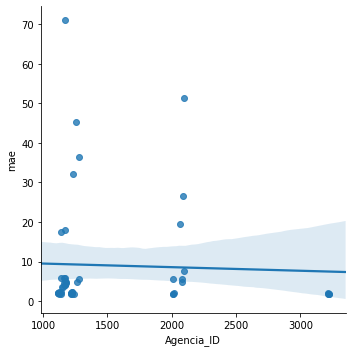

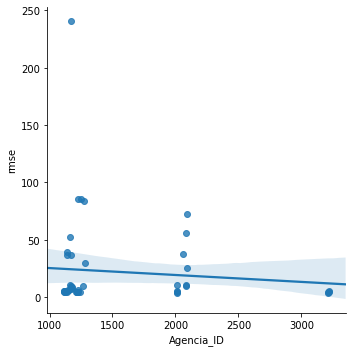

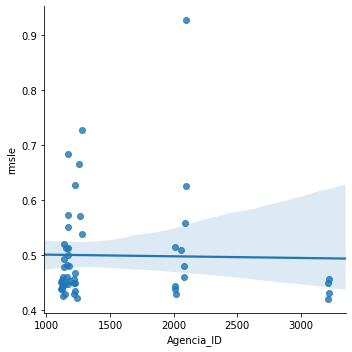

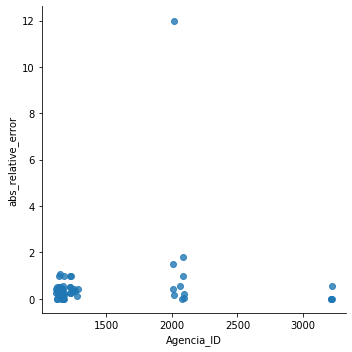

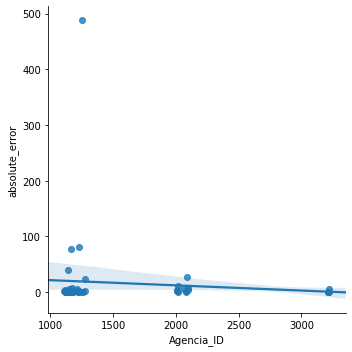

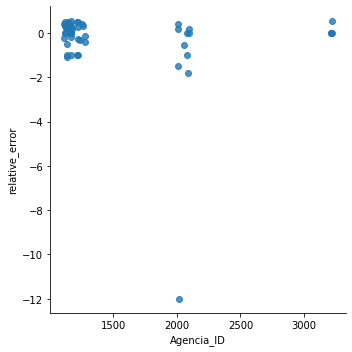

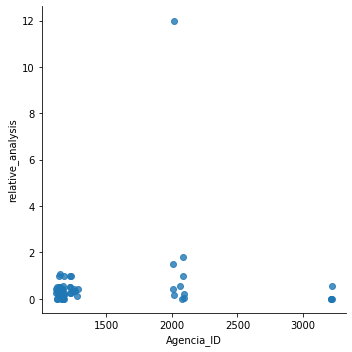

In [116]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="Agencia_ID", y="mae", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Agencia_ID", y="rmse", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Agencia_ID", y="rmsle", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Agencia_ID", y="abs_relative_error", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Agencia_ID", y="absolute_error", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Agencia_ID", y="relative_error", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Agencia_ID", y="relative_analysis", data=df_agencia, fit_reg=True, legend=True)

In [117]:
my_list_1 = []
my_list_2 = []
my_list_3 = []
my_list_4 = []
my_list_5 = []
my_list_6 = []
my_list_7 = []
my_list_8 = []
my_dict = {}
i = 0
for el in df_['Canal_ID'].unique():
    print(f"For Canal_ID = {el}")
    df_filtered = df_.mask('Canal_ID', el)
    
    mae = mean_absolute_error(df_filtered['y_true'], df_filtered['y_pred'])
    print(f'mae: {mae}')
    my_list_1.append(mae)
    
    rmse = np.sqrt(mean_squared_error(df_filtered['y_true'], df_filtered['y_pred']))
    print(f'rmse: {rmse}')
    my_list_2.append(rmse)
    
    rmsle = np.sqrt(mean_squared_log_error(df_filtered['y_true'], df_filtered['y_pred']))
    print(f'rmsle: {rmsle}')
    my_list_3.append(rmsle)
    
    abs_relative_error = df_filtered['abs_relative_error'].iloc[i]
    print(f'abs relative error: {abs_relative_error}')
    my_list_4.append(abs_relative_error)
    
    absolute_error = df_filtered['absolute_error'].iloc[i]
    print(f'absolute error: {absolute_error}')
    my_list_5.append(absolute_error)
    
    relative_error = df_filtered['relative_error'].iloc[i]
    print(f'relative error: {relative_error}')
    my_list_6.append(relative_error)
    
    relative_value = df_filtered['relative_analysis'].iloc[i]
    print(f'abs relative value: {relative_value}')
    my_list_7.append(relative_value)
    
    Demanda_uni_equil = df_filtered['Demanda_uni_equil'].iloc[i]
    my_list_8.append(Demanda_uni_equil)
    
    i = 1
    
    print("__________________________")
    print("__________________________")

my_dict.update( {'mae' : my_list_1} )
my_dict.update( {'rmse' : my_list_2} )
my_dict.update( {'rmsle' : my_list_3} )
my_dict.update( {'abs_relative_error' : my_list_4} )
my_dict.update( {'absolute_error' : my_list_5} )
my_dict.update( {'relative_error' : my_list_6} )
my_dict.update( {'relative_analysis' : my_list_7} )
my_dict.update( {'Demanda_uni_equil' : my_list_8} )
df_agencia = pd.DataFrame(data=my_dict)
df_agencia = pd.concat([df_agencia, pd.DataFrame(df_['Canal_ID'].unique())], \
          axis=1, sort=False)
df_agencia = df_agencia.rename(columns={0: "Canal_ID"})

For Canal_ID = 1
mae: 2.0223884077907957
rmse: 4.578121707016836
rmsle: 0.44404936245414534
abs relative error: 0.4
absolute error: 2
relative error: 0.4
abs relative value: 0.4
__________________________
__________________________
For Canal_ID = 6
mae: 4.825822840733378
rmse: 10.299400236891131
rmsle: 0.492091936356258
abs relative error: 0.2222222222222222
absolute error: 2
relative error: 0.2222222222222222
abs relative value: 0.2222222222222222
__________________________
__________________________
For Canal_ID = 7
mae: 5.28563943796142
rmse: 29.52016518275672
rmsle: 0.5242955297538808
abs relative error: 1.8333333333333333
absolute error: 11
relative error: -1.8333333333333333
abs relative value: 1.8333333333333333
__________________________
__________________________
For Canal_ID = 8
mae: 21.48442367601246
rmse: 121.06392328125345
rmsle: 0.6792115744604628
abs relative error: 1.0
absolute error: 29
relative error: -1.0
abs relative value: 1.0
__________________________
___________

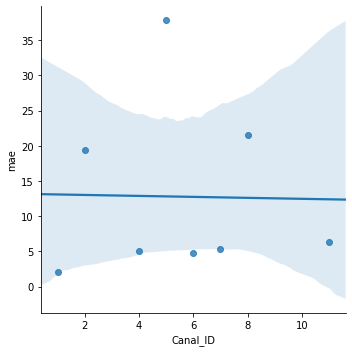

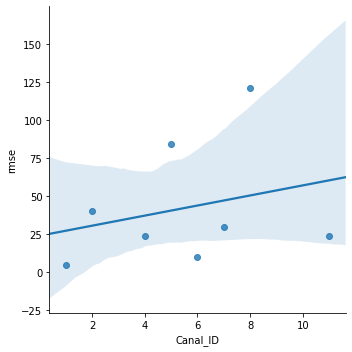

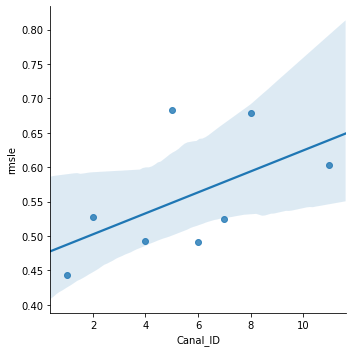

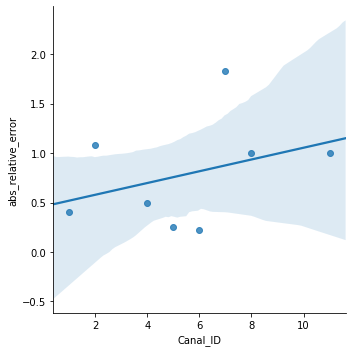

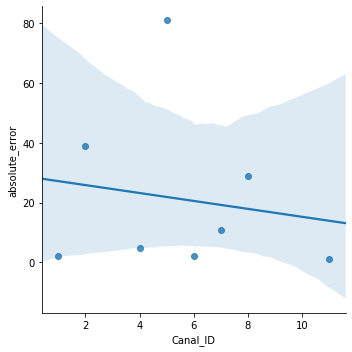

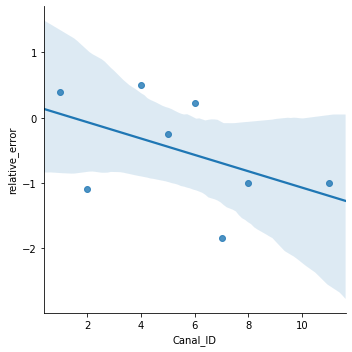

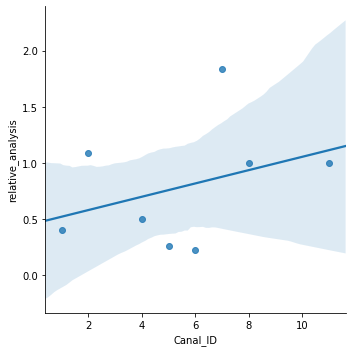

In [118]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="Canal_ID", y="mae", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Canal_ID", y="rmse", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Canal_ID", y="rmsle", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Canal_ID", y="abs_relative_error", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Canal_ID", y="absolute_error", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Canal_ID", y="relative_error", data=df_agencia, fit_reg=True, legend=True)
sns.lmplot( x="Canal_ID", y="relative_analysis", data=df_agencia, fit_reg=True, legend=True)

In [43]:
# Too many routes

# for el in df_['Ruta_SAK'].unique():
#     print(f"For Ruta_SAK = {el}")
#     df_filtered = df_.mask('Ruta_SAK', el)
#     median_relative_value = df_filtered['relative_analysis'].median(skipna = True)
#     print(f'median relative value: {median_relative_value}')
#     mae = mean_absolute_error(df_filtered['y_true'], df_filtered['y_pred'])
#     print(f'mae: {mae}')
#     rmse = np.sqrt(mean_squared_error(df_filtered['y_true'], df_filtered['y_pred']))
#     print(f'rmse: {rmse}')
#     rmsle = np.sqrt(mean_squared_log_error(df_filtered['y_true'], df_filtered['y_pred']))
#     print(f'rmsle: {rmsle}')
#     print("__________________________")
#     print("__________________________")

For Ruta_SAK = 1001
median relative value: 0.3333333333333333
mae: 2.0621592148309706
rmse: 4.054716124962031
rmsle: 0.4195910694981743
__________________________
__________________________
For Ruta_SAK = 1002
median relative value: 0.3333333333333333
mae: 1.97009148486981
rmse: 3.471762030650513
rmsle: 0.42335335057113904
__________________________
__________________________
For Ruta_SAK = 1003
median relative value: 0.3333333333333333
mae: 1.9692307692307693
rmse: 3.458978160458651
rmsle: 0.4330673327969686
__________________________
__________________________
For Ruta_SAK = 1004
median relative value: 0.3333333333333333
mae: 1.9653304442036836
rmse: 3.3898601800734816
rmsle: 0.43004078062003304
__________________________
__________________________
For Ruta_SAK = 1005
median relative value: 0.3333333333333333
mae: 1.9539265062488342
rmse: 3.410512950034648
rmsle: 0.43049680154687947
__________________________
__________________________
For Ruta_SAK = 1007
median relative value: 0.333

rmsle: 0.5045633176657616
__________________________
__________________________
For Ruta_SAK = 4409
median relative value: 0.3333333333333333
mae: 2.2615144418423108
rmse: 5.130764688811933
rmsle: 0.4699193667562447
__________________________
__________________________
For Ruta_SAK = 4410
median relative value: 0.3333333333333333
mae: 2.0862730061349692
rmse: 4.175823272122517
rmsle: 0.449507082115469
__________________________
__________________________
For Ruta_SAK = 4411
median relative value: 0.3333333333333333
mae: 2.3049519059494123
rmse: 4.975751675692289
rmsle: 0.4766259414433651
__________________________
__________________________
For Ruta_SAK = 4412
median relative value: 0.3333333333333333
mae: 2.2794759825327513
rmse: 4.966198911461071
rmsle: 0.4448607876694144
__________________________
__________________________
For Ruta_SAK = 4413
median relative value: 0.3333333333333333
mae: 2.3226609747420848
rmse: 4.473209711463585
rmsle: 0.4376308994511785
_________________________

median relative value: 0.35
mae: 2.8953860210141618
rmse: 6.8353339912576345
rmsle: 0.48207040372601967
__________________________
__________________________
For Ruta_SAK = 1442
median relative value: 0.3333333333333333
mae: 2.650429799426934
rmse: 5.351628125272999
rmsle: 0.4687192899842203
__________________________
__________________________
For Ruta_SAK = 1443
median relative value: 0.375
mae: 2.9210941609679115
rmse: 6.53228134971028
rmsle: 0.5118907571164346
__________________________
__________________________
For Ruta_SAK = 1444
median relative value: 0.3333333333333333
mae: 2.2818352059925093
rmse: 4.835592911060455
rmsle: 0.4470050183123003
__________________________
__________________________
For Ruta_SAK = 1445
median relative value: 0.3333333333333333
mae: 2.4242424242424243
rmse: 5.026229900530517
rmsle: 0.46602844565958884
__________________________
__________________________
For Ruta_SAK = 1446
median relative value: 0.3333333333333333
mae: 2.486126126126126
rmse: 4.479

median relative value: 0.3333333333333333
mae: 1.7262693156732891
rmse: 2.560525608293828
rmsle: 0.422973279636443
__________________________
__________________________
For Ruta_SAK = 1093
median relative value: 0.3550420168067227
mae: 2.2324324324324323
rmse: 4.567215722895018
rmsle: 0.4540393945941817
__________________________
__________________________
For Ruta_SAK = 1094
median relative value: 0.3333333333333333
mae: 2.063063063063063
rmse: 3.4015541404732295
rmsle: 0.44517864780745464
__________________________
__________________________
For Ruta_SAK = 1095
median relative value: 0.3333333333333333
mae: 2.0420650095602295
rmse: 3.4191005492622737
rmsle: 0.4042879299828491
__________________________
__________________________
For Ruta_SAK = 1096
median relative value: 0.2792207792207792
mae: 1.485611510791367
rmse: 2.375686193941938
rmsle: 0.37686036454909055
__________________________
__________________________
For Ruta_SAK = 1097
median relative value: 0.3333333333333333
mae: 2.

rmsle: 0.4180332969027333
__________________________
__________________________
For Ruta_SAK = 1243
median relative value: 0.3333333333333333
mae: 1.5254107756973634
rmse: 2.9525608529496314
rmsle: 0.42803188860512514
__________________________
__________________________
For Ruta_SAK = 1245
median relative value: 0.3333333333333333
mae: 1.3884140550807218
rmse: 2.7858003806238094
rmsle: 0.41746908248972964
__________________________
__________________________
For Ruta_SAK = 1246
median relative value: 0.3333333333333333
mae: 1.8833441348023332
rmse: 8.728199395018217
rmsle: 0.46384812115846175
__________________________
__________________________
For Ruta_SAK = 1247
median relative value: 0.3333333333333333
mae: 1.7102678571428571
rmse: 4.160024467647825
rmsle: 0.43147590842090955
__________________________
__________________________
For Ruta_SAK = 1248
median relative value: 0.3333333333333333
mae: 1.4633991088478675
rmse: 2.7627374131472973
rmsle: 0.42538801245350655
________________

rmsle: 0.3943083870962389
__________________________
__________________________
For Ruta_SAK = 2837
median relative value: 0.3333333333333333
mae: 1.5854522046990667
rmse: 2.9142889598692348
rmsle: 0.44060642070946254
__________________________
__________________________
For Ruta_SAK = 2838
median relative value: 0.3333333333333333
mae: 2.0017937219730944
rmse: 4.395676636670446
rmsle: 0.4431808946238582
__________________________
__________________________
For Ruta_SAK = 4414
median relative value: 0.3333333333333333
mae: 2.2826229508196723
rmse: 4.095979636219871
rmsle: 0.4659831789962683
__________________________
__________________________
For Ruta_SAK = 4415
median relative value: 0.3333333333333333
mae: 2.313970956434652
rmse: 4.533909405993092
rmsle: 0.48934271153652936
__________________________
__________________________
For Ruta_SAK = 4417
median relative value: 0.3333333333333333
mae: 2.1557348298842514
rmse: 3.9437468541206067
rmsle: 0.43066336838779684
____________________

median relative value: 0.3333333333333333
mae: 1.5169628432956381
rmse: 3.654063619724642
rmsle: 0.4710119255869901
__________________________
__________________________
For Ruta_SAK = 1643
median relative value: 0.4
mae: 2.3364140480591495
rmse: 6.947253077546193
rmsle: 0.4911300147223468
__________________________
__________________________
For Ruta_SAK = 1644
median relative value: 0.375
mae: 2.126126126126126
rmse: 6.976050506216297
rmsle: 0.4832490406557776
__________________________
__________________________
For Ruta_SAK = 1645
median relative value: 0.3333333333333333
mae: 1.8500727802037846
rmse: 4.824880929363205
rmsle: 0.47999689412701246
__________________________
__________________________
For Ruta_SAK = 2116
median relative value: 0.3333333333333333
mae: 1.7918842908798713
rmse: 2.8468332621244765
rmsle: 0.41932746801047344
__________________________
__________________________
For Ruta_SAK = 2126
median relative value: 0.3333333333333333
mae: 2.478468899521531
rmse: 4.209

rmsle: 0.48329270603437385
__________________________
__________________________
For Ruta_SAK = 1630
median relative value: 0.3333333333333333
mae: 1.9927737632017788
rmse: 7.29810715063929
rmsle: 0.43918007706501916
__________________________
__________________________
For Ruta_SAK = 1631
median relative value: 0.3333333333333333
mae: 1.3548199767711964
rmse: 3.1572235262790094
rmsle: 0.38119893399332333
__________________________
__________________________
For Ruta_SAK = 1632
median relative value: 0.3333333333333333
mae: 1.3161856963613552
rmse: 3.8528452554064385
rmsle: 0.3710228610019398
__________________________
__________________________
For Ruta_SAK = 1633
median relative value: 0.3333333333333333
mae: 2.58472553699284
rmse: 6.553069568051536
rmsle: 0.5679982352430805
__________________________
__________________________
For Ruta_SAK = 1634
median relative value: 0.3333333333333333
mae: 1.5661881977671452
rmse: 4.137971364998054
rmsle: 0.40803651017067205
_____________________

rmsle: 0.4536499298831204
__________________________
__________________________
For Ruta_SAK = 88
median relative value: 0.2742282388663968
mae: 22.35
rmse: 36.37748518756387
rmsle: 0.9569472946191971
__________________________
__________________________
For Ruta_SAK = 89
median relative value: 0.25
mae: 7.647887323943662
rmse: 10.851753931060255
rmsle: 0.6356413113500163
__________________________
__________________________
For Ruta_SAK = 90
median relative value: 0.16575091575091574
mae: 12.38888888888889
rmse: 22.324003026140073
rmsle: 0.5472764825845496
__________________________
__________________________
For Ruta_SAK = 91
median relative value: 0.25
mae: 8.8203125
rmse: 12.370264245358706
rmsle: 0.5203832262910179
__________________________
__________________________
For Ruta_SAK = 92
median relative value: 0.2727272727272727
mae: 20.1588785046729
rmse: 34.548219046028066
rmsle: 0.408351815790452
__________________________
__________________________
For Ruta_SAK = 93
median relat

median relative value: 0.20344827586206898
mae: 11.552631578947368
rmse: 16.5537402356529
rmsle: 0.38606872178829277
__________________________
__________________________
For Ruta_SAK = 140
median relative value: 0.21174463937621832
mae: 19.208333333333332
rmse: 27.172289806590342
rmsle: 0.43652918217078807
__________________________
__________________________
For Ruta_SAK = 141
median relative value: 0.25344036697247707
mae: 13.592105263157896
rmse: 20.214963191707902
rmsle: 0.7229843157093617
__________________________
__________________________
For Ruta_SAK = 142
median relative value: 0.33854166666666663
mae: 13.09375
rmse: 19.110697266190996
rmsle: 0.4332786367886198
__________________________
__________________________
For Ruta_SAK = 143
median relative value: 0.270772238514174
mae: 13.913793103448276
rmse: 25.119370187580135
rmsle: 0.618273839743406
__________________________
__________________________
For Ruta_SAK = 145
median relative value: 0.30495169082125606
mae: 26.9459459

rmsle: 0.48395809529227357
__________________________
__________________________
For Ruta_SAK = 3346
median relative value: 0.3333333333333333
mae: 6.317164179104478
rmse: 11.630345023821707
rmsle: 0.5410033908935473
__________________________
__________________________
For Ruta_SAK = 2708
median relative value: 0.38571428571428573
mae: 40.0
rmse: 53.511680967803656
rmsle: 0.5759241795347351
__________________________
__________________________
For Ruta_SAK = 2716
median relative value: 0.175
mae: 7.0
rmse: 7.0
rmsle: 0.1872115006829107
__________________________
__________________________
For Ruta_SAK = 2718
median relative value: 0.54
mae: 42.333333333333336
rmse: 46.87927758260217
rmsle: 0.802202816453443
__________________________
__________________________
For Ruta_SAK = 2723
median relative value: 0.21428571428571427
mae: 15.0
rmse: 21.435951110226018
rmsle: 0.4109669492306448
__________________________
__________________________
For Ruta_SAK = 2882
median relative value: 0.08333

median relative value: 0.32142857142857145
mae: 16.0
rmse: 19.714630776828326
rmsle: 0.43304950404407255
__________________________
__________________________
For Ruta_SAK = 7408
median relative value: 0.40476190476190477
mae: 76.0
rmse: 111.89504010455512
rmsle: 0.6334424084077716
__________________________
__________________________
For Ruta_SAK = 7413
median relative value: 0.4318877551020408
mae: 70.0
rmse: 96.99226773305179
rmsle: 0.8599463947581588
__________________________
__________________________
For Ruta_SAK = 7420
median relative value: 0.42
mae: 40.0
rmse: 47.35680169380811
rmsle: 0.5366202982504384
__________________________
__________________________
For Ruta_SAK = 7422
median relative value: 0.34285714285714286
mae: 27.0
rmse: 31.965606517005117
rmsle: 0.4038425463392666
__________________________
__________________________
For Ruta_SAK = 7427
median relative value: 0.35
mae: 14.666666666666666
rmse: 20.639767440550294
rmsle: 0.48909688642729965
_______________________

median relative value: 0.8944444444444444
mae: 34.5
rmse: 36.36619309193636
rmsle: 0.8764650255563255
__________________________
__________________________
For Ruta_SAK = 7987
median relative value: 0.6475694444444444
mae: 39.75
rmse: 45.74658457196559
rmsle: 0.8358265671268446
__________________________
__________________________
For Ruta_SAK = 7988
median relative value: 3.1
mae: 62.0
rmse: 62.0
rmsle: 1.3743180839165934
__________________________
__________________________
For Ruta_SAK = 7989
median relative value: 0.8511904761904762
mae: 70.0
rmse: 87.7762306474063
rmsle: 1.2922384121298673
__________________________
__________________________
For Ruta_SAK = 7990
median relative value: 0.5416666666666666
mae: 22.0
rmse: 26.166135875720485
rmsle: 0.5182298795058715
__________________________
__________________________
For Ruta_SAK = 8084
median relative value: 8.333333333333334
mae: 100.0
rmse: 100.0
rmsle: 2.1624385446492305
__________________________
__________________________
For

median relative value: 0.18333333333333335
mae: 10.818181818181818
rmse: 17.212574684594028
rmsle: 0.3879864034507922
__________________________
__________________________
For Ruta_SAK = 49
median relative value: 0.325
mae: 21.4
rmse: 44.8986513036738
rmsle: 0.4930355633861637
__________________________
__________________________
For Ruta_SAK = 50
median relative value: 0.3313008130081301
mae: 17.444444444444443
rmse: 25.816123299640132
rmsle: 0.5745070156885117
__________________________
__________________________
For Ruta_SAK = 51
median relative value: 0.24242424242424243
mae: 5.48
rmse: 6.925315877272314
rmsle: 0.5883216414252098
__________________________
__________________________
For Ruta_SAK = 52
median relative value: 0.275
mae: 10.0
rmse: 15.583874449479593
rmsle: 0.5028119008888617
__________________________
__________________________
For Ruta_SAK = 53
median relative value: 0.1369047619047619
mae: 2.8333333333333335
rmse: 3.6285901761795403
rmsle: 0.3027346741614674
_______

mae: 2.393939393939394
rmse: 4.573272779402505
rmsle: 0.44191962261246687
__________________________
__________________________
For Ruta_SAK = 1104
median relative value: 0.36363636363636365
mae: 2.966808914177335
rmse: 5.684739539508658
rmsle: 0.4672657566580205
__________________________
__________________________
For Ruta_SAK = 1105
median relative value: 0.3333333333333333
mae: 3.0037140204271124
rmse: 5.732589401326145
rmsle: 0.47688871334513555
__________________________
__________________________
For Ruta_SAK = 1106
median relative value: 0.3333333333333333
mae: 2.7481641468682505
rmse: 7.087237944690811
rmsle: 0.4897013496921071
__________________________
__________________________
For Ruta_SAK = 1107
median relative value: 0.36363636363636365
mae: 2.2321711568938194
rmse: 4.292402900758568
rmsle: 0.4528921707321746
__________________________
__________________________
For Ruta_SAK = 1108
median relative value: 0.375
mae: 3.0966921119592876
rmse: 6.1118081181662145
rmsle: 0.461

rmse: 64.7708782298547
rmsle: 2.0683276760818474
__________________________
__________________________
For Ruta_SAK = 2158
median relative value: 0.3333333333333333
mae: 2.1818652849740934
rmse: 3.4674653656779566
rmsle: 0.4806955839768575
__________________________
__________________________
For Ruta_SAK = 2159
median relative value: 0.3333333333333333
mae: 2.0337899543378994
rmse: 3.3666372800381192
rmsle: 0.41577834371964506
__________________________
__________________________
For Ruta_SAK = 2160
median relative value: 0.3333333333333333
mae: 2.3895976447497547
rmse: 3.8853793532100984
rmsle: 0.4442198563994079
__________________________
__________________________
For Ruta_SAK = 2161
median relative value: 0.4
mae: 2.5645390070921987
rmse: 3.7805024244880845
rmsle: 0.5213884466182082
__________________________
__________________________
For Ruta_SAK = 2162
median relative value: 0.3333333333333333
mae: 2.4950099800399204
rmse: 4.292452643955295
rmsle: 0.4857909763243148
___________

rmsle: 0.4562573370949747
__________________________
__________________________
For Ruta_SAK = 2834
median relative value: 0.3333333333333333
mae: 1.5807622504537204
rmse: 2.810080376810943
rmsle: 0.41301676441381857
__________________________
__________________________
For Ruta_SAK = 2839
median relative value: 0.3333333333333333
mae: 1.5815804434337692
rmse: 2.8617967457499875
rmsle: 0.4173022103720876
__________________________
__________________________
For Ruta_SAK = 2840
median relative value: 0.25
mae: 1.4643449419568824
rmse: 3.053149965164569
rmsle: 0.3912528398444364
__________________________
__________________________
For Ruta_SAK = 4430
median relative value: 0.3333333333333333
mae: 1.7528015820698748
rmse: 3.376115260445471
rmsle: 0.39481249715809025
__________________________
__________________________
For Ruta_SAK = 4431
median relative value: 0.3196428571428571
mae: 2.03887399463807
rmse: 3.9531437925408204
rmsle: 0.408251042257336
__________________________
__________

median relative value: 0.3092708836310961
mae: 44.52755905511811
rmse: 83.95710378276844
rmsle: 0.7211290013795182
__________________________
__________________________
For Ruta_SAK = 3005
median relative value: 0.32653061224489793
mae: 59.81651376146789
rmse: 102.77319823392361
rmsle: 0.5129175276877174
__________________________
__________________________
For Ruta_SAK = 3006
median relative value: 0.2476993865030675
mae: 32.18115942028985
rmse: 71.1643841062184
rmsle: 0.6851970687107872
__________________________
__________________________
For Ruta_SAK = 3007
median relative value: 0.19558823529411765
mae: 34.544642857142854
rmse: 80.54673665465464
rmsle: 0.7990152299868714
__________________________
__________________________
For Ruta_SAK = 3008
median relative value: 0.26229508196721313
mae: 37.7029702970297
rmse: 51.20914212934798
rmsle: 0.6369313713376964
__________________________
__________________________
For Ruta_SAK = 3009
median relative value: 0.24807692307692308
mae: 38.0

median relative value: 0.3617021276595745
mae: 4.764505119453925
rmse: 9.07232975786787
rmsle: 0.4961774854850466
__________________________
__________________________
For Ruta_SAK = 6620
median relative value: 0.3333333333333333
mae: 7.256360078277886
rmse: 14.91567950539405
rmsle: 0.49456578123514905
__________________________
__________________________
For Ruta_SAK = 6621
median relative value: 0.3333333333333333
mae: 4.780689655172414
rmse: 8.814251782355585
rmsle: 0.5166683777110269
__________________________
__________________________
For Ruta_SAK = 6622
median relative value: 0.3333333333333333
mae: 4.2481121898597625
rmse: 7.3931073762968005
rmsle: 0.500393941080001
__________________________
__________________________
For Ruta_SAK = 6623
median relative value: 0.375
mae: 5.45320197044335
rmse: 9.935175769445982
rmsle: 0.5270361709533048
__________________________
__________________________
For Ruta_SAK = 6624
median relative value: 0.3333333333333333
mae: 5.349593495934959
rms

median relative value: 0.25
mae: 1.655421686746988
rmse: 2.990345912214638
rmsle: 0.3923399210517114
__________________________
__________________________
For Ruta_SAK = 2844
median relative value: 0.3333333333333333
mae: 1.6
rmse: 3.3922031562866524
rmsle: 0.4430872555750637
__________________________
__________________________
For Ruta_SAK = 2847
median relative value: 0.25
mae: 1.336016096579477
rmse: 2.4238918105093563
rmsle: 0.3398232689663381
__________________________
__________________________
For Ruta_SAK = 2848
median relative value: 0.3333333333333333
mae: 1.697151424287856
rmse: 3.8028632785629144
rmsle: 0.3867795051695959
__________________________
__________________________
For Ruta_SAK = 2849
median relative value: 0.3333333333333333
mae: 3.6218274111675126
rmse: 23.953264563493864
rmsle: 0.4696384383286362
__________________________
__________________________
For Ruta_SAK = 2852
median relative value: 0.3333333333333333
mae: 1.1794392523364485
rmse: 1.8770627283022026
r

median relative value: 0.375
mae: 28.566037735849058
rmse: 59.07749946803966
rmsle: 0.7374941040254616
__________________________
__________________________
For Ruta_SAK = 7250
median relative value: 0.25
mae: 36.7375
rmse: 72.97919223998029
rmsle: 0.4822504263707192
__________________________
__________________________
For Ruta_SAK = 7252
median relative value: 0.3157894736842105
mae: 23.163636363636364
rmse: 33.06412502450902
rmsle: 0.5560441756026032
__________________________
__________________________
For Ruta_SAK = 7254
median relative value: 0.23076923076923078
mae: 10.81081081081081
rmse: 14.60470120534129
rmsle: 0.3885137894402248
__________________________
__________________________
For Ruta_SAK = 7256
median relative value: 0.3125
mae: 21.11111111111111
rmse: 33.95421754199158
rmsle: 0.5278850404636851
__________________________
__________________________
For Ruta_SAK = 7259
median relative value: 0.26666666666666666
mae: 8.736842105263158
rmse: 12.703087067820624
rmsle: 0.7

In [44]:
# Too much clients

# for el in df_['Cliente_ID'].unique():
#     print(f"For Cliente_ID = {el}")
#     df_filtered = df_.mask('Cliente_ID', el)
#     median_relative_value = df_filtered['relative_analysis'].median(skipna = True)
#     print(f'median relative value: {median_relative_value}')
#     mae = mean_absolute_error(df_filtered['y_true'], df_filtered['y_pred'])
#     print(f'mae: {mae}')
#     rmse = np.sqrt(mean_squared_error(df_filtered['y_true'], df_filtered['y_pred']))
#     print(f'rmse: {rmse}')
#     rmsle = np.sqrt(mean_squared_log_error(df_filtered['y_true'], df_filtered['y_pred']))
#     print(f'rmsle: {rmsle}')
#     print("__________________________")
#     print("__________________________")

In [45]:
for el in df_['Producto_ID'].unique():
    print(f"For Producto_ID = {el}")
    df_filtered = df_.mask('Producto_ID', el)
    median_relative_value = df_filtered['relative_analysis'].median(skipna = True)
    print(f'median relative value: {median_relative_value}')
    mae = mean_absolute_error(df_filtered['y_true'], df_filtered['y_pred'])
    print(f'mae: {mae}')
    rmse = np.sqrt(mean_squared_error(df_filtered['y_true'], df_filtered['y_pred']))
    print(f'rmse: {rmse}')
    rmsle = np.sqrt(mean_squared_log_error(df_filtered['y_true'], df_filtered['y_pred']))
    print(f'rmsle: {rmsle}')
    print("__________________________")
    print("__________________________")

For Producto_ID = 1109
median relative value: 0.3333333333333333
mae: 1.1043650369102387
rmse: 1.9518516965868935
rmsle: 0.3578201147737866
__________________________
__________________________
For Producto_ID = 1125
median relative value: 0.4
mae: 2.9583106004685646
rmse: 5.5143714917538595
rmsle: 0.5176333408224778
__________________________
__________________________
For Producto_ID = 1129
median relative value: 0.3333333333333333
mae: 1.661376213845672
rmse: 3.0375465333485003
rmsle: 0.43345027138158343
__________________________
__________________________
For Producto_ID = 1146
median relative value: 0.3333333333333333
mae: 1.2742441209406494
rmse: 3.006152705260667
rmsle: 0.36060910478343916
__________________________
__________________________
For Producto_ID = 1150
median relative value: 0.3333333333333333
mae: 1.9951309603760914
rmse: 4.247396785007828
rmsle: 0.41438128694397003
__________________________
__________________________
For Producto_ID = 2233
median relative value:

median relative value: 0.0
mae: 0.7084261225335335
rmse: 1.2486462709548467
rmsle: 0.3573841432492551
__________________________
__________________________
For Producto_ID = 31423
median relative value: 0.3333333333333333
mae: 1.070402462661042
rmse: 1.72867398929315
rmsle: 0.3849707040724727
__________________________
__________________________
For Producto_ID = 41843
median relative value: 0.375
mae: 3.3290312548592755
rmse: 6.900688320759339
rmsle: 0.551006753652565
__________________________
__________________________
For Producto_ID = 1212
median relative value: 0.3333333333333333
mae: 1.0578580221583915
rmse: 1.9452727947847681
rmsle: 0.3961697649224741
__________________________
__________________________
For Producto_ID = 1216
median relative value: 0.29705882352941176
mae: 0.8867672586460141
rmse: 1.702424966861319
rmsle: 0.37448711754748754
__________________________
__________________________
For Producto_ID = 48421
median relative value: 0.4
mae: 2.6200551977920883
rmse: 4.

median relative value: inf
mae: 1.9901185770750989
rmse: 4.053252244178829
rmsle: 0.9206501529396013
__________________________
__________________________
For Producto_ID = 44292
median relative value: 0.25
mae: 0.75
rmse: 1.1579762911688178
rmsle: 0.4308287412117521
__________________________
__________________________
For Producto_ID = 49990
median relative value: 0.5
mae: 0.8125
rmse: 1.0307764064044151
rmsle: 0.3851771101530756
__________________________
__________________________
For Producto_ID = 35305
median relative value: 0.3333333333333333
mae: 3.5197890878693374
rmse: 6.465631590131483
rmsle: 0.4960177186392161
__________________________
__________________________
For Producto_ID = 37361
median relative value: 0.3333333333333333
mae: 1.956327431125191
rmse: 3.1725651181972276
rmsle: 0.4302026176129458
__________________________
__________________________
For Producto_ID = 30532
median relative value: 0.3333333333333333
mae: 2.390151681688283
rmse: 4.252536000000892
rmsle: 0.

median relative value: 0.3333333333333333
mae: 1.4074074074074074
rmse: 2.499259149487363
rmsle: 0.4090792621088486
__________________________
__________________________
For Producto_ID = 36610
median relative value: 0.1
mae: 8.302628285356695
rmse: 19.546606797514006
rmsle: 0.5635071254673715
__________________________
__________________________
For Producto_ID = 31695
median relative value: 0.36964285714285716
mae: 47.04819277108434
rmse: 104.27466048507235
rmsle: 0.6115011128513572
__________________________
__________________________
For Producto_ID = 46716
median relative value: 0.3333333333333333
mae: 1.1411764705882352
rmse: 1.704664879951827
rmsle: 0.4154662528848976
__________________________
__________________________
For Producto_ID = 37427
median relative value: 0.4
mae: 2.570048309178744
rmse: 6.215766146845499
rmsle: 0.5502520119763346
__________________________
__________________________
For Producto_ID = 32846
median relative value: 0.3333333333333333
mae: 2.125
rmse: 6

rmsle: 0.5666789437311224
__________________________
__________________________
For Producto_ID = 1700
median relative value: 0.3333333333333333
mae: 4.482084690553746
rmse: 8.814039733115463
rmsle: 0.5540731918565805
__________________________
__________________________
For Producto_ID = 6420
median relative value: 0.375
mae: 1.4931506849315068
rmse: 4.018791476489773
rmsle: 0.43757306007899743
__________________________
__________________________
For Producto_ID = 37360
median relative value: 0.3333333333333333
mae: 7.089179548156956
rmse: 17.844352817272494
rmsle: 0.5958344098977826
__________________________
__________________________
For Producto_ID = 5310
median relative value: 0.3333333333333333
mae: 9.3296
rmse: 18.920648332795928
rmsle: 0.5579633180736305
__________________________
__________________________
For Producto_ID = 31506
median relative value: 0.3333333333333333
mae: 6.0376068376068375
rmse: 10.746178012686272
rmsle: 0.5749483366841395
__________________________
___

median relative value: 1.1666666666666667
mae: 8.444444444444445
rmse: 10.099504938362077
rmsle: 0.8518266173867151
__________________________
__________________________
For Producto_ID = 35739
median relative value: 0.6666666666666666
mae: 4.0
rmse: 4.0
rmsle: 0.8472978075004083
__________________________
__________________________
For Producto_ID = 30375
median relative value: 0.2714285714285714
mae: 25.454545454545453
rmse: 47.72389598444247
rmsle: 0.6007525603581898
__________________________
__________________________
For Producto_ID = 30423
median relative value: 0.2777777777777778
mae: 11.142857142857142
rmse: 17.84590122342356
rmsle: 0.41253085147119944
__________________________
__________________________
For Producto_ID = 31467
median relative value: 0.375
mae: 16.372093023255815
rmse: 24.885318357767535
rmsle: 0.6066143097786713
__________________________
__________________________
For Producto_ID = 31498
median relative value: 0.42857142857142855
mae: 12.532710280373832
rms

median relative value: 0.22777777777777777
mae: 10.6
rmse: 23.125310808722116
rmsle: 0.3935155272156675
__________________________
__________________________
For Producto_ID = 43161
median relative value: 0.22539682539682537
mae: 11.111842105263158
rmse: 17.194514119028597
rmsle: 0.3997797412800696
__________________________
__________________________
For Producto_ID = 43169
median relative value: 0.25
mae: 4.088353413654619
rmse: 5.8919317237855875
rmsle: 0.47768773878225324
__________________________
__________________________
For Producto_ID = 43173
median relative value: 0.21597222222222223
mae: 13.158823529411764
rmse: 19.941237202753257
rmsle: 0.3888997780552669
__________________________
__________________________
For Producto_ID = 43174
median relative value: 0.3333333333333333
mae: 6.2052980132450335
rmse: 8.835884091709172
rmsle: 0.5818420580741233
__________________________
__________________________
For Producto_ID = 43196
median relative value: 0.29411764705882354
mae: 8.7

median relative value: 0.55
mae: 13.0
rmse: 17.3908021666627
rmsle: 0.6890134812185316
__________________________
__________________________
For Producto_ID = 35244
median relative value: 0.26904761904761904
mae: 13.964285714285714
rmse: 17.613914953808536
rmsle: 0.5058311768964247
__________________________
__________________________
For Producto_ID = 35247
median relative value: 0.21250000000000002
mae: 9.777777777777779
rmse: 13.29578045011942
rmsle: 0.4283883271494719
__________________________
__________________________
For Producto_ID = 43192
median relative value: 0.17430142006413193
mae: 25.133333333333333
rmse: 37.14386445520534
rmsle: 0.27943484077203334
__________________________
__________________________
For Producto_ID = 43195
median relative value: 0.5925925925925926
mae: 8.2
rmse: 11.704699910719626
rmsle: 0.6919458099902767
__________________________
__________________________
For Producto_ID = 43348
median relative value: 0.20526315789473684
mae: 29.5
rmse: 37.6455508

median relative value: 0.11363636363636363
mae: 20.666666666666668
rmse: 21.087120871912948
rmsle: 0.13964286168452825
__________________________
__________________________
For Producto_ID = 32142
median relative value: 0.09883720930232558
mae: 15.6
rmse: 19.00526242912736
rmsle: 0.14561540446002488
__________________________
__________________________
For Producto_ID = 43360
median relative value: 0.27525252525252525
mae: 24.9
rmse: 35.37371905808039
rmsle: 0.5002143848258208
__________________________
__________________________
For Producto_ID = 43361
median relative value: 0.3451548451548452
mae: 19.4
rmse: 27.633313228782395
rmsle: 0.38599430511400246
__________________________
__________________________
For Producto_ID = 43394
median relative value: 0.12121212121212122
mae: 10.2
rmse: 10.853570840972107
rmsle: 0.1681813516409833
__________________________
__________________________
For Producto_ID = 48125
median relative value: 0.0625
mae: 13.0
rmse: 18.211717839530316
rmsle: 0.23

For Producto_ID = 33300
median relative value: 0.14039408866995073
mae: 13.542168674698795
rmse: 18.88072900369166
rmsle: 0.282512285056229
__________________________
__________________________
For Producto_ID = 3977
median relative value: 0.25
mae: 6.238095238095238
rmse: 11.862305244525016
rmsle: 0.4270263887906465
__________________________
__________________________
For Producto_ID = 3978
median relative value: 0.55
mae: 3.1666666666666665
rmse: 4.0
rmsle: 0.6099682636817646
__________________________
__________________________
For Producto_ID = 40985
median relative value: 0.25
mae: 50.970873786407765
rmse: 96.49427771152008
rmsle: 0.5127812230792531
__________________________
__________________________
For Producto_ID = 31277
median relative value: 0.35416666666666663
mae: 2.9
rmse: 4.898979485566356
rmsle: 0.46798154419000965
__________________________
__________________________
For Producto_ID = 8931
median relative value: 0.3333333333333333
mae: 3.9122085048010975
rmse: 6.2827

median relative value: 0.5813333333333334
mae: 872.0
rmse: 872.0
rmsle: 0.8697553857556137
__________________________
__________________________
For Producto_ID = 36557
median relative value: 0.6272222222222222
mae: 1129.0
rmse: 1129.0
rmsle: 0.9858392241741161
__________________________
__________________________
For Producto_ID = 36561
median relative value: 0.7413194444444444
mae: 2135.0
rmse: 2135.0
rmsle: 1.3511671915442864
__________________________
__________________________
For Producto_ID = 36562
median relative value: 0.524074074074074
mae: 566.0
rmse: 566.0
rmsle: 0.7414750556656093
__________________________
__________________________
For Producto_ID = 36699
median relative value: 0.9496527777777778
mae: 2735.0
rmse: 2735.0
rmsle: 2.9822861700397105
__________________________
__________________________
For Producto_ID = 36700
median relative value: 0.7285714285714285
mae: 1836.0
rmse: 1836.0
rmsle: 1.302991974115704
__________________________
__________________________
For 

median relative value: 0.27450980392156865
mae: 23.28846153846154
rmse: 32.35708221133002
rmsle: 0.3794281756099454
__________________________
__________________________
For Producto_ID = 45294
median relative value: 0.25901639344262295
mae: 27.64516129032258
rmse: 37.54008610160783
rmsle: 0.3889309801874543
__________________________
__________________________
For Producto_ID = 45295
median relative value: 0.31285757302017464
mae: 25.508474576271187
rmse: 33.50663986815505
rmsle: 0.45578595060479915
__________________________
__________________________
For Producto_ID = 45296
median relative value: 0.32973789235249706
mae: 52.28125
rmse: 67.76821710802196
rmsle: 0.4454744418918876
__________________________
__________________________
For Producto_ID = 45447
median relative value: 0.21264367816091953
mae: 37.621212121212125
rmse: 49.49977043105627
rmsle: 0.43569243595458756
__________________________
__________________________
For Producto_ID = 45449
median relative value: 0.2403100775

median relative value: inf
mae: 1.0
rmse: 1.0
rmsle: 0.6931471805599453
__________________________
__________________________
For Producto_ID = 34781
median relative value: 2.7
mae: 81.0
rmse: 81.0
rmsle: 1.2845117306395766
__________________________
__________________________
For Producto_ID = 37426
median relative value: 0.15
mae: 1.5
rmse: 2.1213203435596424
rmsle: 0.22518083756523433
__________________________
__________________________
For Producto_ID = 31484
median relative value: 0.347953216374269
mae: 3.5
rmse: 4.949747468305833
rmsle: 0.5194895777335742
__________________________
__________________________
For Producto_ID = 31624
median relative value: 0.5
mae: 2.0
rmse: 3.0382181012509997
rmsle: 0.39391565374090887
__________________________
__________________________
For Producto_ID = 33671
median relative value: 0.4375
mae: 3.5
rmse: 3.8078865529319543
rmsle: 0.6003194323480779
__________________________
__________________________
For Producto_ID = 31782
median relative val

__________________________
For Producto_ID = 5919
median relative value: 0.3333333333333333
mae: 1.4285714285714286
rmse: 3.372154885444702
rmsle: 0.3668509388237488
__________________________
__________________________
For Producto_ID = 5921
median relative value: 0.4
mae: 1.6666666666666667
rmse: 3.1419412584889095
rmsle: 0.39935891815696833
__________________________
__________________________
For Producto_ID = 35895
median relative value: 0.25
mae: 1.4333333333333333
rmse: 2.652043237455478
rmsle: 0.33785391151134425
__________________________
__________________________
For Producto_ID = 4859
median relative value: 0.6086956521739131
mae: 14.0
rmse: 14.0
rmsle: 0.45953230383038957
__________________________
__________________________
For Producto_ID = 6507
median relative value: 0.2222222222222222
mae: 8.0
rmse: 8.0
rmsle: 0.24362197663889207
__________________________
__________________________
For Producto_ID = 43034
median relative value: 0.125
mae: 2.0
rmse: 2.0
rmsle: 0.125163

### What Gabrielle is expecting from me

In [383]:
new_train_df

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,short_name,brand,Town,State
75360,3,1112,1,1001,327267,693,5,48.000000,0,0.0,5,Tostada Plana,MR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75361,3,1112,1,1001,327267,1109,5,75.050003,0,0.0,5,Pan Blanco Chico,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75362,3,1112,1,1001,327267,1125,10,96.000000,0,0.0,10,Tortillinas,TR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75363,3,1112,1,1001,327267,1129,4,70.400002,0,0.0,4,Tortillinas,TR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75364,3,1112,1,1001,327267,1146,2,42.779999,0,0.0,2,Pan Integral,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75365,3,1112,1,1001,327267,1150,2,27.920000,0,0.0,2,Medias Noches,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75366,3,1112,1,1001,327267,1182,5,69.699997,0,0.0,5,Tostado,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75367,3,1112,1,1001,327267,2233,4,79.760002,0,0.0,4,Pan Blanco,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75368,3,1112,1,1001,327267,4767,3,44.369999,0,0.0,3,Tostado Doble Fibra,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75369,3,1112,1,1001,327267,32802,1,11.910000,0,0.0,1,Tortillas de Maiz,MR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO


In [393]:
new_train_df_ = new_train_df.copy()

In [394]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

new_train_df_['Producto_ID'] = le.fit_transform(new_train_df_['Agencia_ID'])

In [395]:
# Create data
a1_df = new_train_df_[new_train_df_['Semana'] == 3]
a2_df = new_train_df_[new_train_df_['Semana'] == 4]
a3_df = new_train_df_[new_train_df_['Semana'] == 5]
a4_df = new_train_df_[new_train_df_['Semana'] == 6]
a5_df = new_train_df_[new_train_df_['Semana'] == 7]
a6_df = new_train_df_[new_train_df_['Semana'] == 8]
a7_df = new_train_df_[new_train_df_['Semana'] == 9]

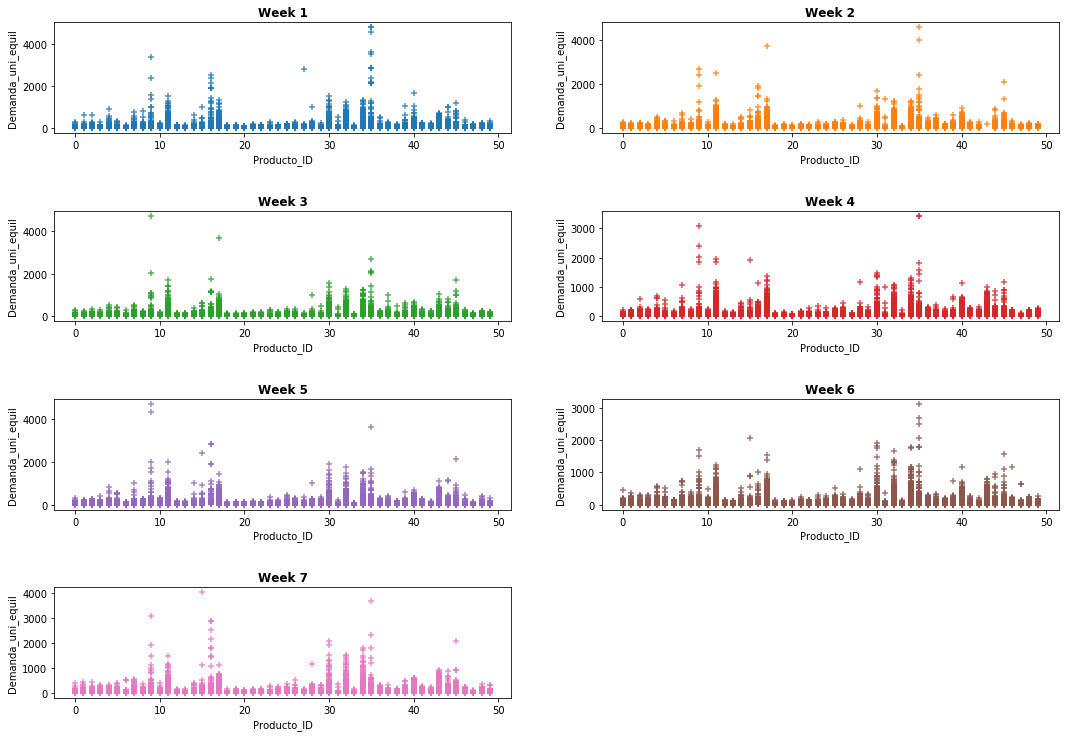

In [404]:
fig = plt.figure(figsize=(18, 15))

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots,
               # expressed as a fraction of the average axis width
hspace = 0.7   # the amount of height reserved for white space between subplots,
               # expressed as a fraction of the average axis height

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

# Create a figure instance, and the 7 subplots (for each week)
a1 = fig.add_subplot(521)
a2 = fig.add_subplot(522)
a3 = fig.add_subplot(523)
a4 = fig.add_subplot(524)
a5 = fig.add_subplot(525)
a6 = fig.add_subplot(526)
a7 = fig.add_subplot(527)

# Create a figure instance, and the 7 subplots (for each week)
a1.title.set_text('Week 1')
a1.title.set_fontweight('bold')
a2.title.set_text('Week 2')
a2.title.set_fontweight('bold')
a3.title.set_text('Week 3')
a3.title.set_fontweight('bold')
a4.title.set_text('Week 4')
a4.title.set_fontweight('bold')
a5.title.set_text('Week 5')
a5.title.set_fontweight('bold')
a6.title.set_text('Week 6')
a6.title.set_fontweight('bold')
a7.title.set_text('Week 7')
a7.title.set_fontweight('bold')

# Tell pointplot to plot on ax1 with the ax argument
sns.regplot(x=a1_df['Producto_ID'], y=a1_df['Demanda_uni_equil'], fit_reg=False, data=a1_df, marker="+", ci=None, ax=a1)
sns.regplot(x=a2_df['Producto_ID'], y=a2_df['Demanda_uni_equil'], fit_reg=False, data=a2_df, marker="+", ci=None, ax=a2)
sns.regplot(x=a3_df['Producto_ID'], y=a3_df['Demanda_uni_equil'], fit_reg=False, data=a3_df, marker="+", ci=None, ax=a3)
sns.regplot(x=a4_df['Producto_ID'], y=a4_df['Demanda_uni_equil'], fit_reg=False, data=a4_df, marker="+", ci=None, ax=a4)
sns.regplot(x=a5_df['Producto_ID'], y=a5_df['Demanda_uni_equil'], fit_reg=False, data=a5_df, marker="+", ci=None, ax=a5)
sns.regplot(x=a6_df['Producto_ID'], y=a6_df['Demanda_uni_equil'], fit_reg=False, data=a6_df, marker="+", ci=None, ax=a6)
sns.regplot(x=a7_df['Producto_ID'], y=a7_df['Demanda_uni_equil'], fit_reg=False, data=a7_df, marker="+", ci=None, ax=a7)


plt.show()
fig.savefig("../images/regplot3.pdf")


In [185]:
a1_df.head(3)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,short_name,brand,Town,State
75360,3,1112,1,1001,327267,693,5,48.000000,0,0.0,5,Tostada Plana,MR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75361,3,1112,1,1001,327267,1109,5,75.050003,0,0.0,5,Pan Blanco Chico,BIM,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
75362,3,1112,1,1001,327267,1125,10,96.000000,0,0.0,10,Tortillinas,TR,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO


In [186]:
df_agencia.head(3)

,mae,rmse,rmsle,abs_relative_error,absolute_error,relative_error,relative_analysis,Demanda_uni_equil,Canal_ID
0,2.022388,4.578122,0.444049,0.400000,2,0.400000,0.400000,5,1
1,4.825823,10.299400,0.492092,0.222222,2,0.222222,0.222222,9,6
2,5.285639,29.520165,0.524296,1.833333,11,-1.833333,1.833333,6,7


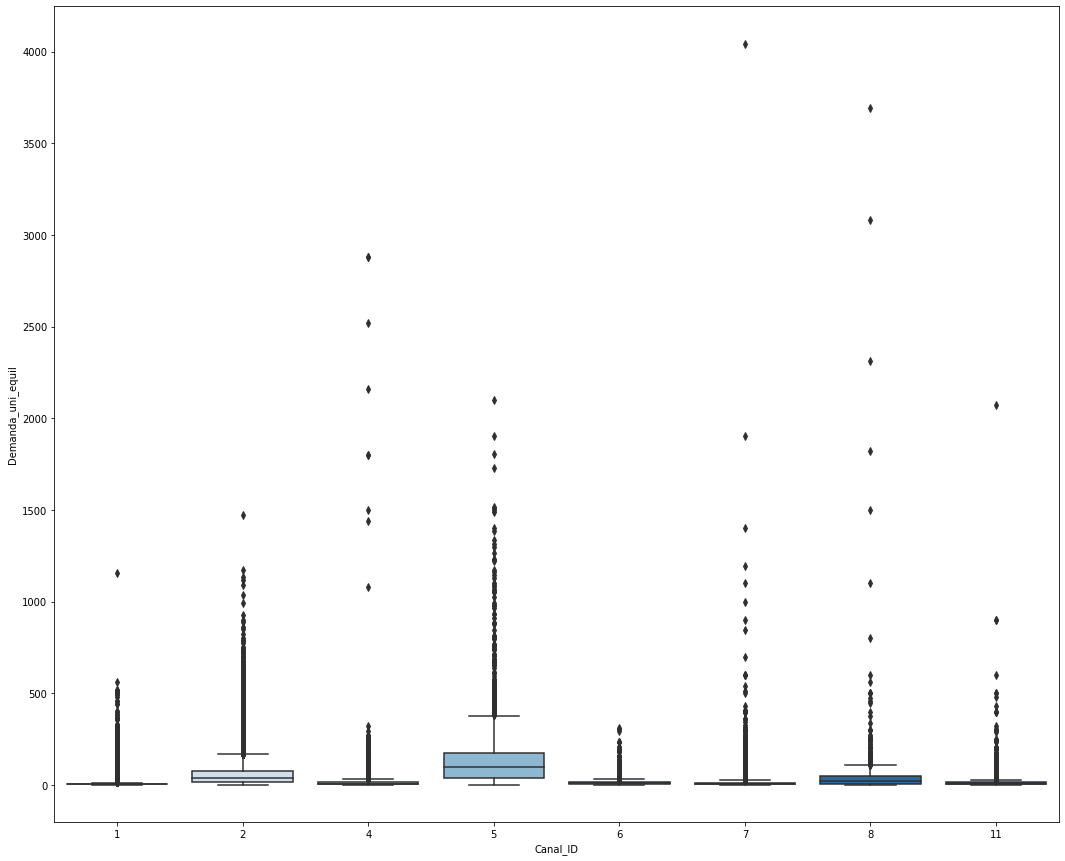

In [188]:
fig1 = plt.figure(figsize=(18, 15))

# Grouped boxplot
sns.boxplot(x=df_['Canal_ID'], y=df_['Demanda_uni_equil'], data=df_agencia, palette="Blues")
fig1.savefig("../images/boxplot1.png")

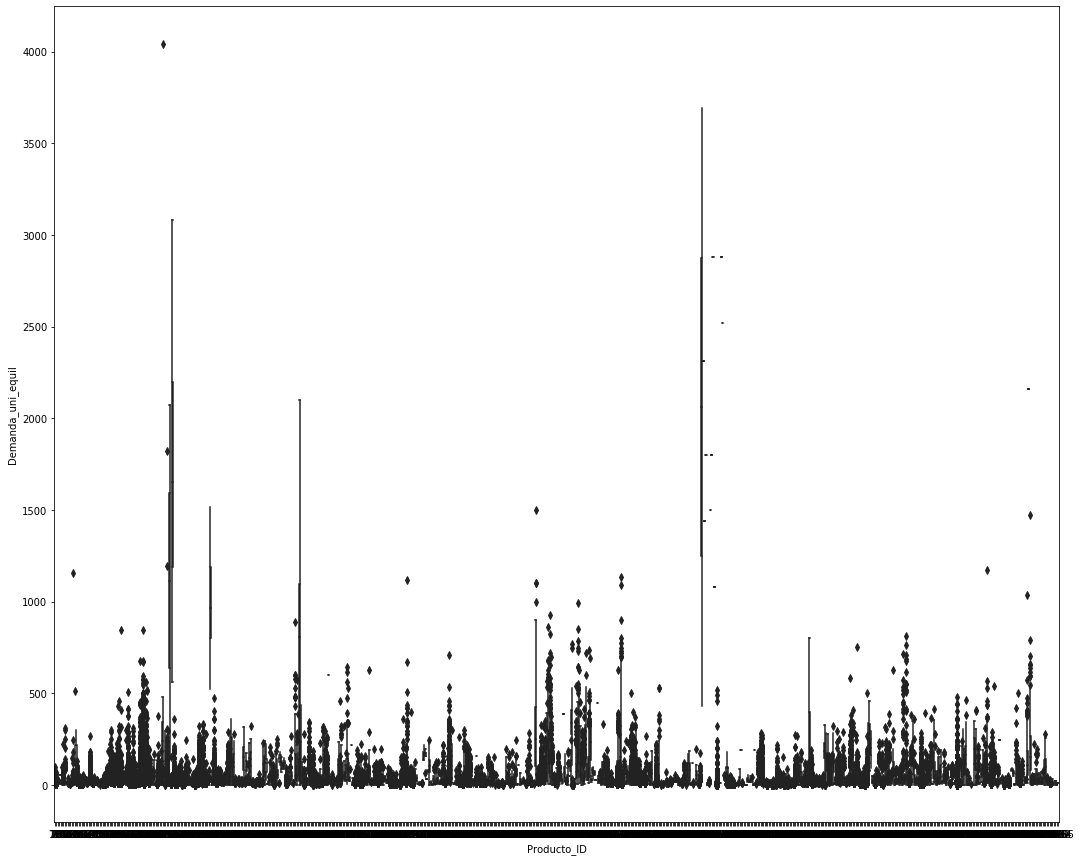

In [189]:
fig1 = plt.figure(figsize=(18, 15))

# Grouped boxplot
sns.boxplot(x=df_['Producto_ID'], y=df_['Demanda_uni_equil'], data=df_agencia, palette="Blues")
fig1.savefig("../images/boxplot2.png")

### Parallel plot

In [408]:
def create_conditions_to_par(nb_of_products, filter_agencia, filter_ruta, filter_cliente, filter_canal):

    for el in new_train_df.short_name.unique()[0: nb_of_products]:
        df_filtered = new_train_df
#         df_filtered = df_filtered.mask('Agencia_ID', filter_agencia)
#         df_filtered = df_filtered.mask('Ruta_SAK', filter_ruta)
        df_filtered = df_filtered.mask('Cliente_ID', filter_cliente)
#         df_filtered = df_filtered.mask('Canal_ID', filter_canal)

    df_filtered = df_filtered[['Semana', 'short_name', 'Demanda_uni_equil']]

    my_list_of_lists = []
    for el in df_filtered.short_name.unique()[0: nb_of_products]:
        my_list = []
        my_list.append(f"{el}")
        try:
            my_list.append(df_filtered.mask('short_name', el).mask('Semana', 3)['Demanda_uni_equil'].iloc[0])
        except IndexError:
            my_list.append(0)
        try:
            my_list.append(df_filtered.mask('short_name', el).mask('Semana', 4)['Demanda_uni_equil'].iloc[0])
        except IndexError:
            my_list.append(0)
        try:
            my_list.append(df_filtered.mask('short_name', el).mask('Semana', 5)['Demanda_uni_equil'].iloc[0])
        except IndexError:
            my_list.append(0)
        try:
            my_list.append(df_filtered.mask('short_name', el).mask('Semana', 6)['Demanda_uni_equil'].iloc[0])
        except IndexError:
            my_list.append(0)
        try:
            my_list.append(df_filtered.mask('short_name', el).mask('Semana', 7)['Demanda_uni_equil'].iloc[0])
        except IndexError:
            my_list.append(0)
        try:
            my_list.append(df_filtered.mask('short_name', el).mask('Semana', 8)['Demanda_uni_equil'].iloc[0])
        except IndexError:
            my_list.append(0)
        try:
            my_list.append(df_filtered.mask('short_name', el).mask('Semana', 9)['Demanda_uni_equil'].iloc[0])
        except IndexError:
            my_list.append(0)
        my_list_of_lists.append(my_list)
    return my_list_of_lists

In [409]:
conditions = create_conditions_to_par(nb_of_products=15,
                                      filter_agencia=1112, 
                                      filter_ruta=1001, 
                                      filter_cliente=327444,
                                      filter_canal=1,
                                     )

conditions

[['Pan Blanco Chico ', 1, 0, 0, 1, 0, 0, 0],
 ['Tortillinas ', 2, 3, 0, 0, 0, 2, 2],
 ['Pan Molido ', 3, 6, 0, 0, 0, 0, 0],
 ['Roles Glass ', 2, 2, 2, 1, 2, 1, 2],
 ['Panque Nuez ', 1, 0, 0, 0, 0, 0, 0],
 ['Panquecito Gota Choc ', 2, 2, 0, 0, 1, 2, 1],
 ['Mantecadas Vainilla ', 2, 2, 2, 2, 3, 4, 0],
 ['Donas Azucar ', 1, 0, 0, 0, 5, 4, 1],
 ['Bimbunuelos ', 1, 0, 0, 0, 0, 0, 0],
 ['Conchas Vainilla ', 1, 2, 1, 1, 1, 0, 0],
 ['Madalenas ', 6, 10, 5, 3, 6, 7, 8],
 ['Cuernitos Famili Pack ', 2, 2, 2, 2, 0, 0, 0],
 ['Principe ', 5, 0, 0, 0, 0, 0, 0],
 ['Canelitas ', 5, 0, 0, 0, 0, 0, 0],
 ['Polvoron ', 4, 0, 0, 4, 0, 0, 0]]

In [423]:
# current_palette = sns.color_palette()
# sns.palplot(current_palette)

In [424]:
# sns.palplot(sns.color_palette("Paired"))

In [426]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


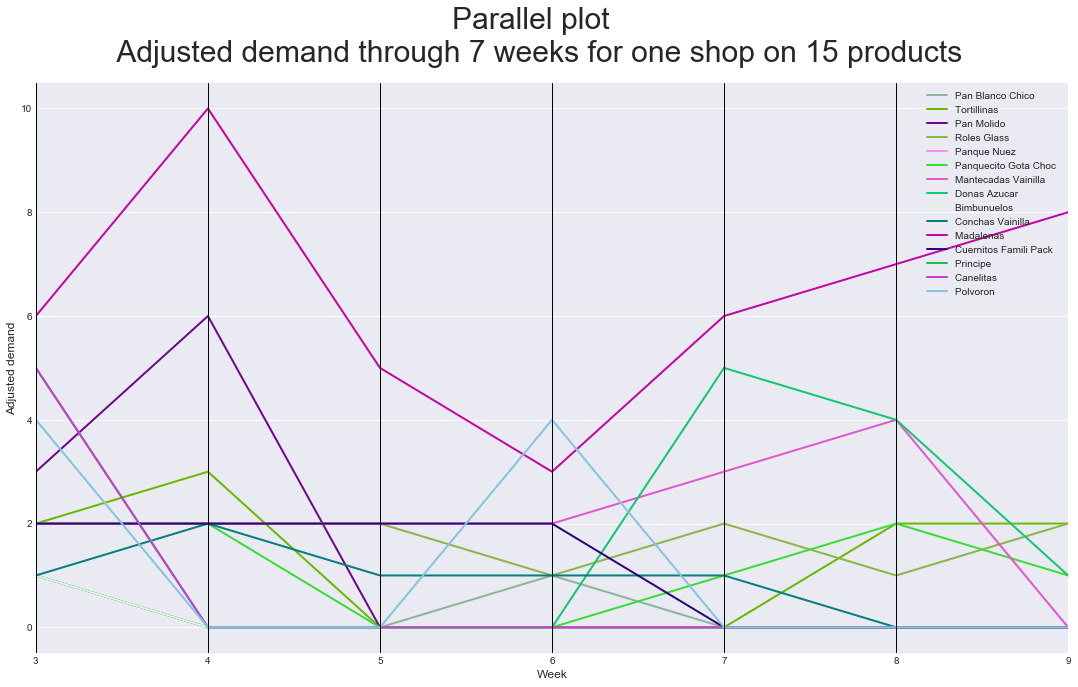

In [435]:
# Set the color palette
plt.style.use('seaborn-colorblind')
from pandas.plotting import parallel_coordinates

par_df = pd.DataFrame(conditions, \
    columns=["Semana", 3, 4, 5, 6, 7, 8, 9])

parallel_coordinates(par_df, "Semana")
fig = plt.gcf()
fig.suptitle(f"Parallel plot \n Adjusted demand through 7 weeks for one shop on 15 products", fontsize=30)
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
plt.ylabel("Adjusted demand")
plt.xlabel("Week")
plt.show()
fig.savefig('parallel_plot_1.pdf')

### It is the afternoon

In [441]:
df_.columns

Index(['mean_due_agencia', 'mean_due_canal', 'mean_due_ruta',
       'mean_due_cliente', 'mean_due_prod_age', 'mean_due_prod_rut',
       'mean_due_prod_cli', 'mean_due_prod_can', 'mean_due_prod_cli_age',
       'mean_vh_agencia', 'std_due_acrcp', 'mean_due_acrcp',
       'mean_due_cli_clu', 'max_due_prod_cli', 'y_pred', 'y_true',
       'y_pred_unrounded', 'relative_analysis', 'abs_relative_error',
       'absolute_error', 'relative_error', 'relative_analysis (%)', 'Semana',
       'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID',
       'Venta_uni_hoy', 'Venta_hoy', 'Dev_uni_proxima', 'Dev_proxima',
       'Demanda_uni_equil', 'short_name', 'brand', 'Town', 'State'],
      dtype='object')

In [475]:
my_list_ordered[0:10]

[2094, 1253, 1167, 1276, 1228, 2087, 1168, 2061, 1142, 1176]

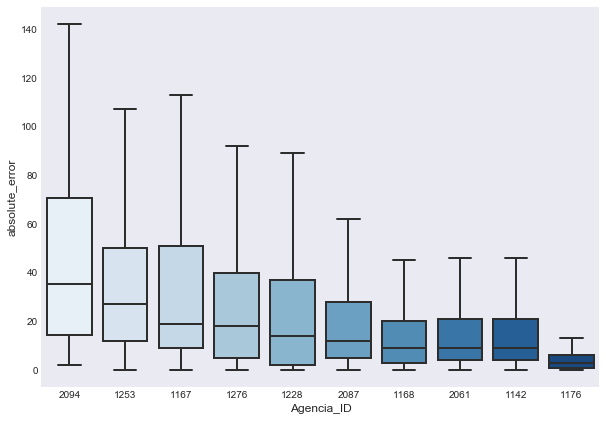

In [477]:
my_list_ordered = []
for el in df_.groupby('Agencia_ID')['absolute_error'].median().sort_values(ascending=False).index:
    my_list_ordered.append(el)

fig1 = plt.figure(figsize=(10, 7))

# Grouped boxplot
sns.boxplot(x=df_['Agencia_ID'], y=df_['absolute_error'], data=df_, palette="Blues", showfliers = False,
           order=my_list_ordered[0: 10]
           )
# fig1.savefig("../images/boxplot3.png")

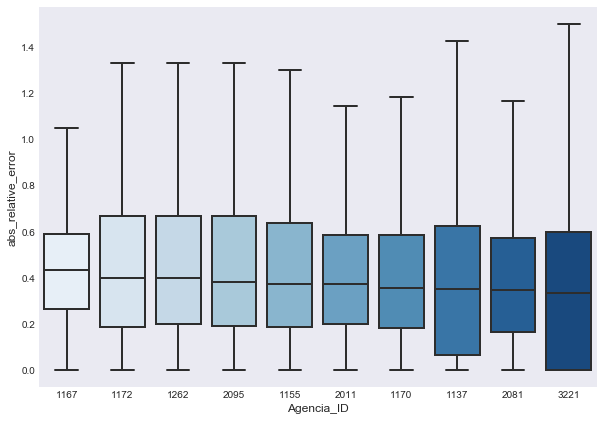

In [478]:
my_list_ordered = []
for el in df_.groupby('Agencia_ID')['abs_relative_error'].median().sort_values(ascending=False).index:
    my_list_ordered.append(el)

fig1 = plt.figure(figsize=(10, 7))

# Grouped boxplot
sns.boxplot(x=df_['Agencia_ID'], y=df_['abs_relative_error'], data=df_, palette="Blues", showfliers = False,
           order=my_list_ordered[0: 10]
           )
# fig1.savefig("../images/boxplot3.png")

In [494]:
df_['short_name'].nunique()

381

Text(0.5, 0, 'Category')

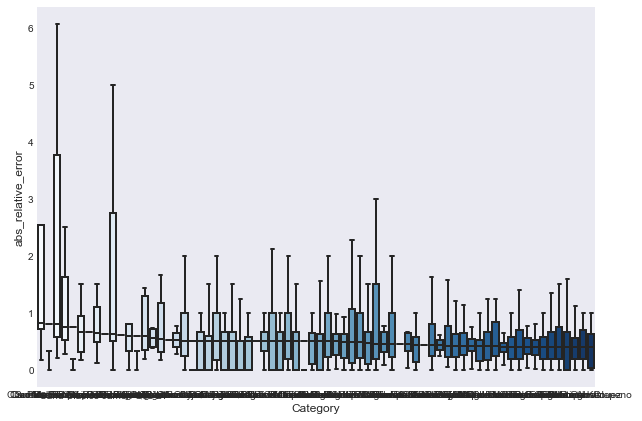

In [492]:
my_list_ordered = []
for el in df_.groupby('short_name')['abs_relative_error'].median().sort_values(ascending=False).index:
    my_list_ordered.append(el)

fig1 = plt.figure(figsize=(10, 7))

# Grouped boxplot
sns.boxplot(x=df_['short_name'], y=df_['abs_relative_error'], data=df_, palette="Blues", showfliers = False,
           order=my_list_ordered[30:100]
           )
plt.xlabel("Category")
# fig1.savefig("../images/boxplot3.png")